In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget

# locals
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
# load cluster assignments
cdf = pd.read_csv("clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


done


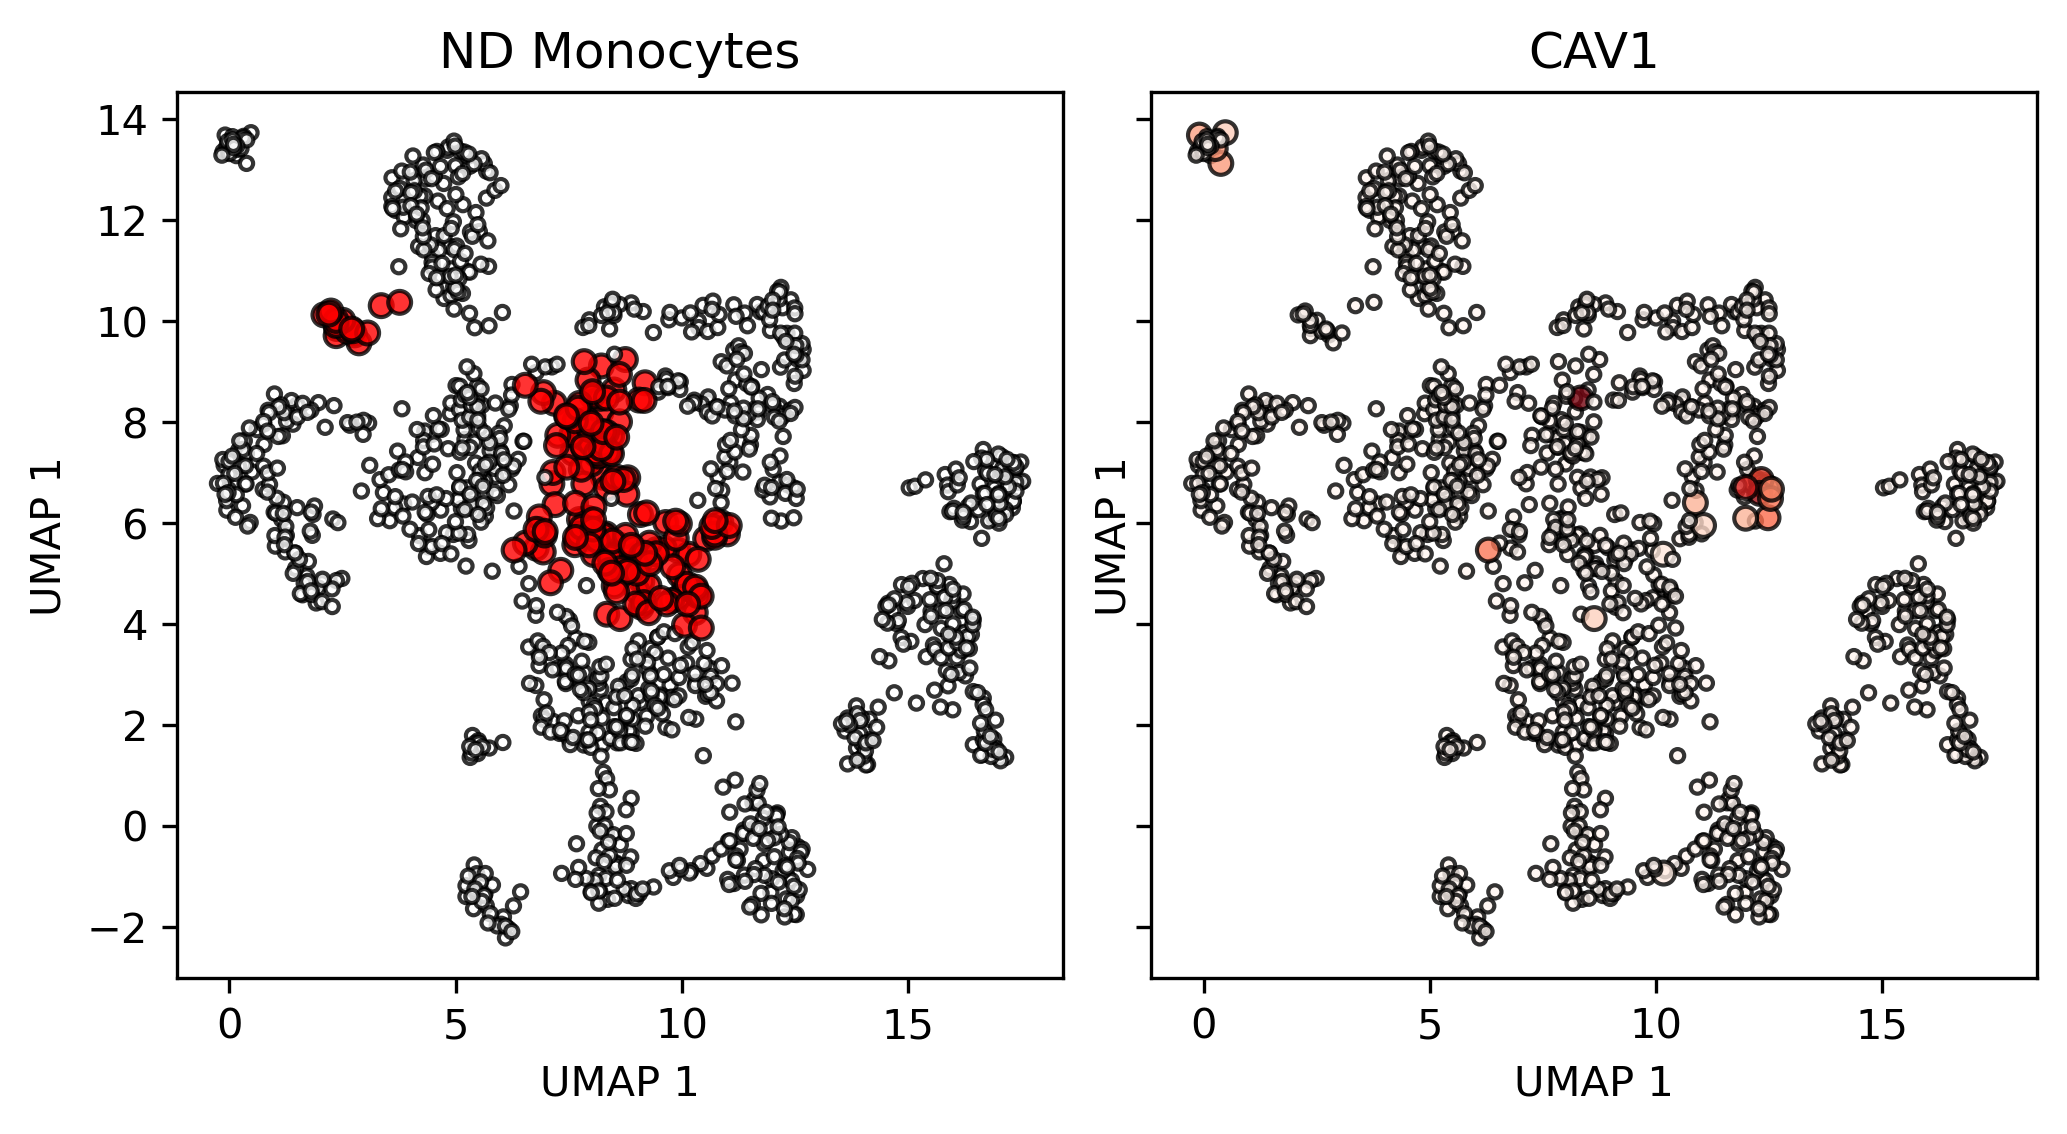

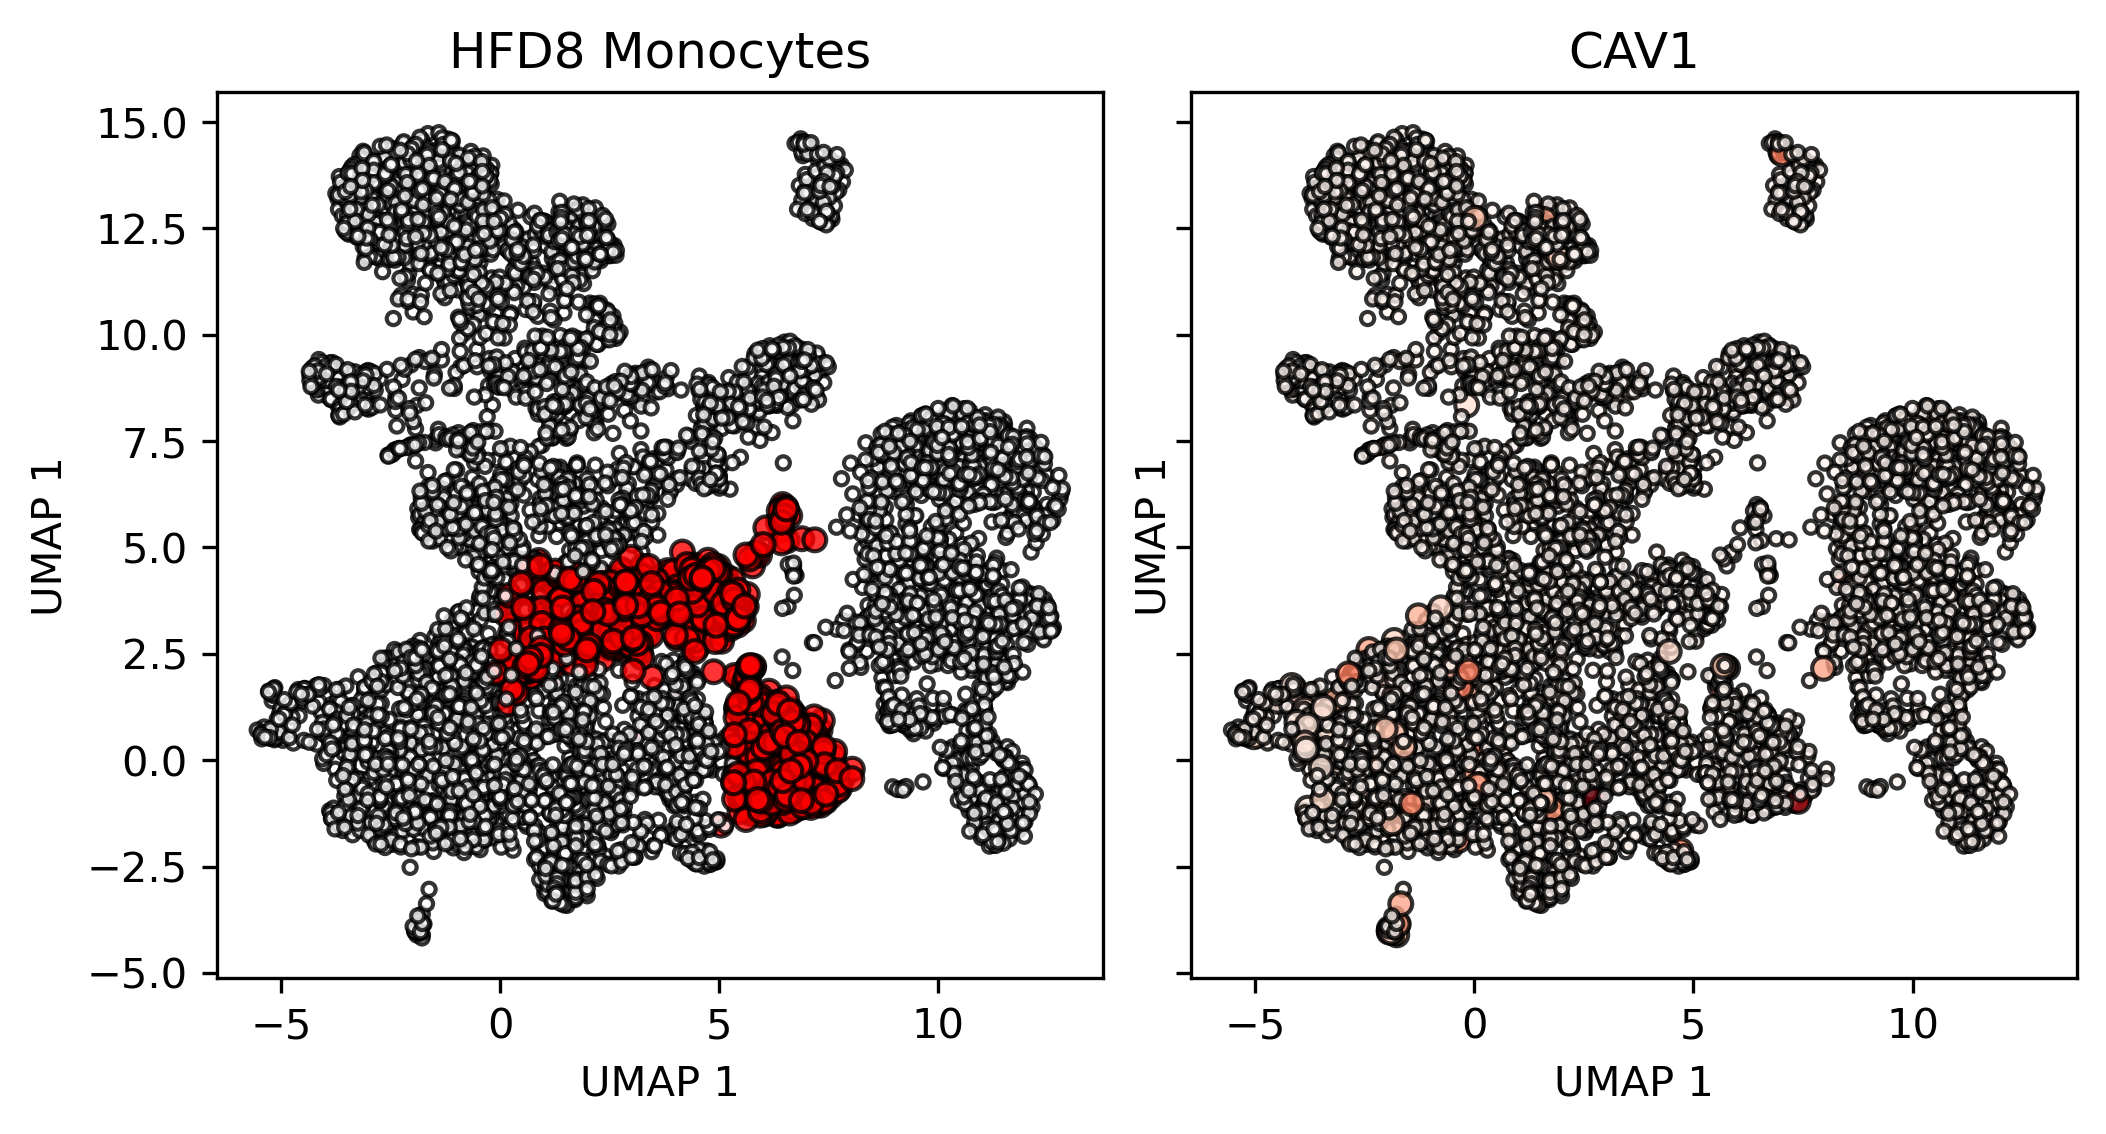

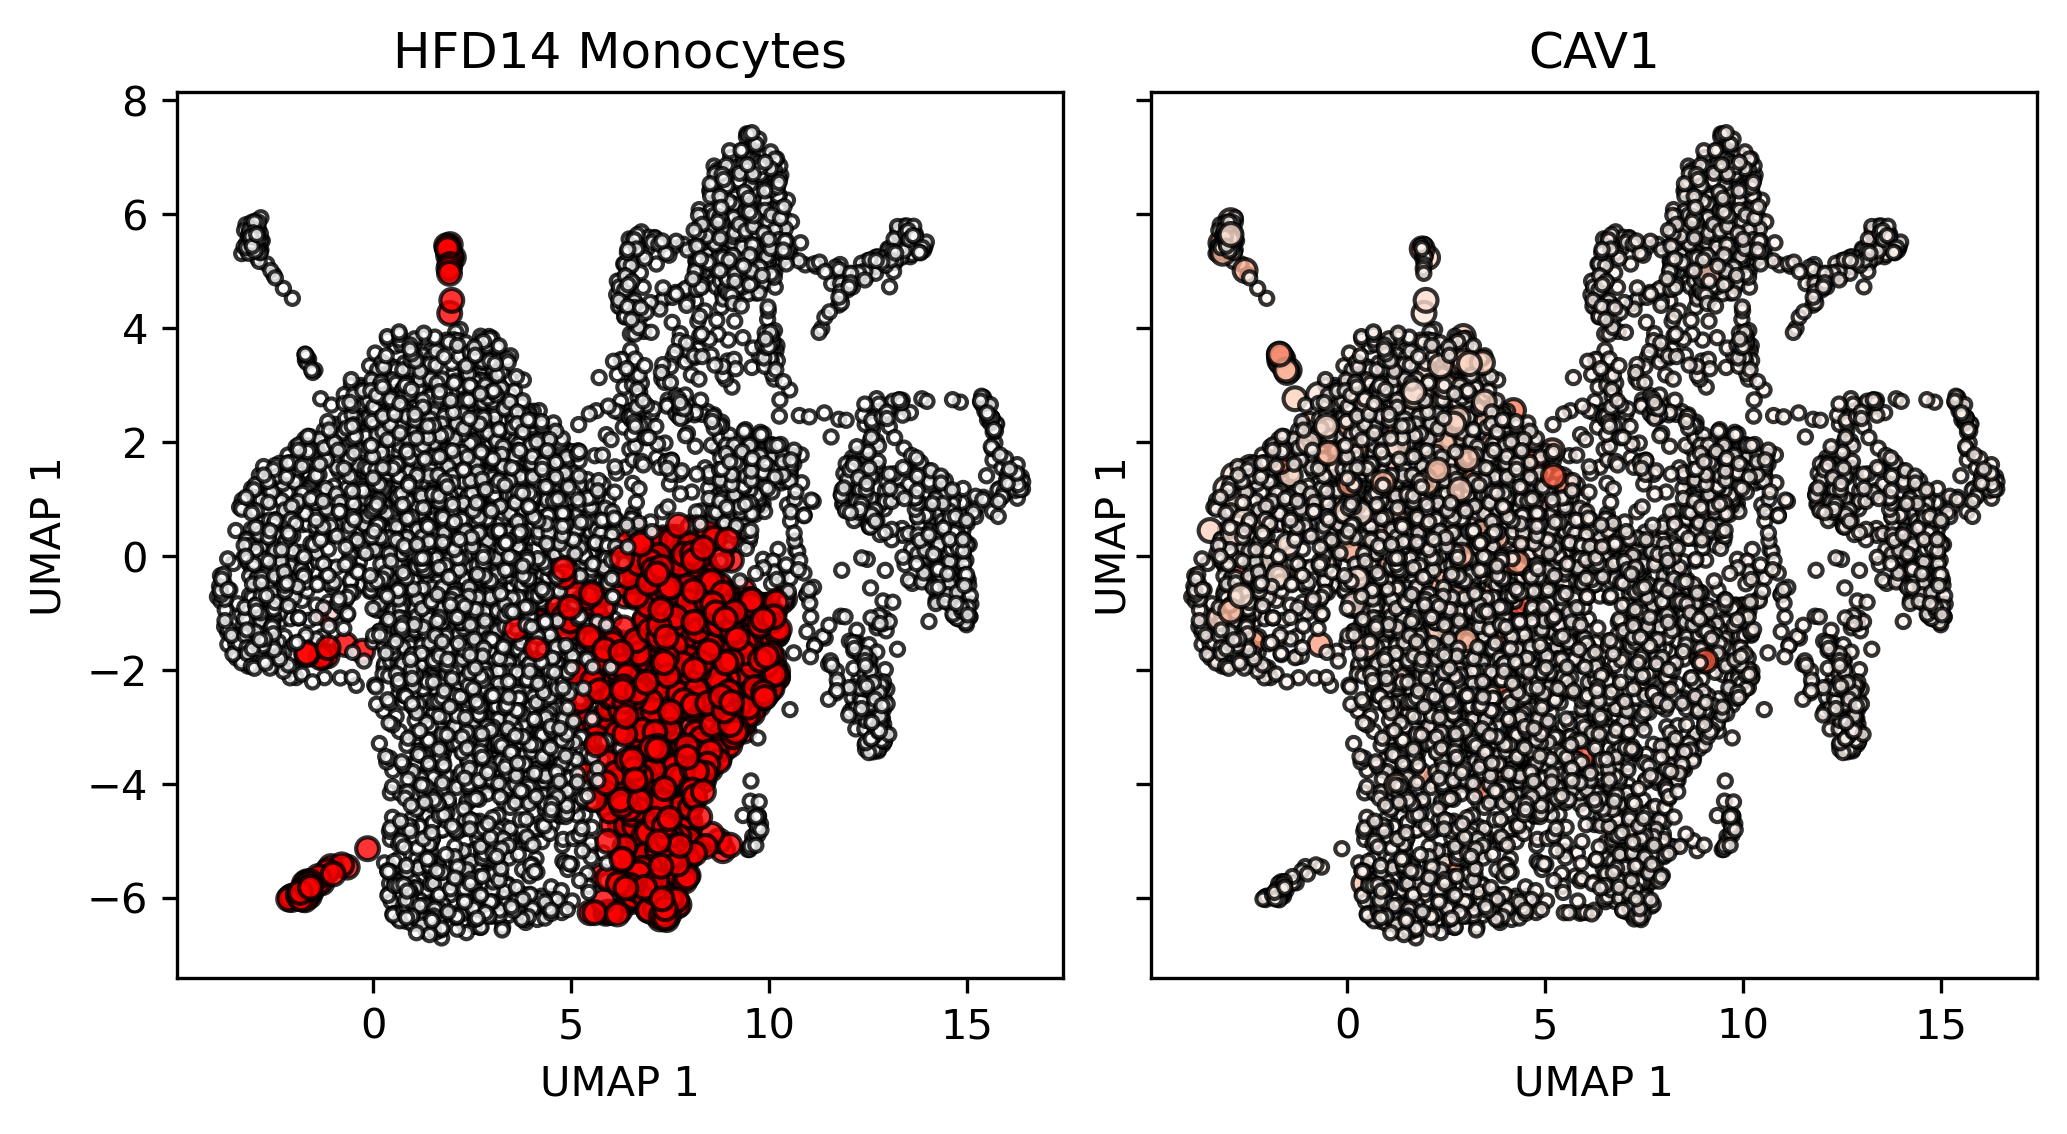

In [13]:
runKey = "nn15_pca30_r0.75"

plt.rcParams['figure.dpi'] = 300
pltSize = 4
keys = ['ND', 'HFD8', 'HFD14']
query = ['CAV1']
query = [x.upper() for x in query]
ctype = 'Monocytes'

res = []

for key in keys:
    data = adata[key]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
        
    # set up th plot
    nPlots = len(query) + 1

    plt.rcParams['figure.figsize'] = nPlots*pltSize, pltSize
        
    fig, axs = plt.subplots(1, nPlots, sharey=True, subplot_kw=dict(box_aspect=1))
    axs = axs.ravel()

    cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
        
    mask = clusterIds.isin(cellTypeIds)        
    c = np.where(mask, 'r', 'w')
    s = np.where(mask, 30, 10)
    y_true = np.where(mask, 1, 0)

    axs[0].scatter(embedding[: , 0], 
                   embedding[:, 1], 
                   c=c,
                   edgecolor="k",
                   s=s,
                   alpha=0.8)

    axs[0].set_title(f"{key} {ctype}")
    axs[0].set_xlabel("UMAP 1")
    axs[0].set_ylabel("UMAP 1")


    # plot the expression of each validation gene
    for i, g in enumerate(query):
        plotNum = i + 1

        mask = df[g] > 0
        c = np.where(mask, "tomato", "w")
        s = np.where(mask, 30, 10)
        y_pred = np.where(mask, 1, 0)

        axs[plotNum].scatter(embedding[: , 0] , 
                             embedding[:, 1] , 
                             c=df[g],
                             cmap='Reds',
                             edgecolor="k",
                             s=s,
                             alpha=0.8)

        axs[plotNum].set_title(g)
        axs[plotNum].set_xlabel("UMAP 1")
        axs[plotNum].set_ylabel("UMAP 1")

        """Compute jaccard sim with the label """

        row = {
            'Key' : key,
            'cellType' : ctype,
            'Gene' : g,
            'jaccrd' : metrics.jaccard_score(y_true, y_pred),
            'accuracy' : metrics.accuracy_score(y_true, y_pred),
            'precision' : metrics.precision_score(y_true, y_pred),
        }

        res.append(row)

    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)


res = pd.DataFrame(res)
print('done')

In [14]:
# res.head()